# Solving PDE (diffusion in insulated rod)

## The problem

We consider the diffusion problem

$$
    \begin{cases}
        \frac{\partial T}{\partial t} = k\frac{\partial^2 T}{\partial x^2} \quad &\text{ in } [a,b], \quad 0<t<t_\text{end}, \\
        T = T_0 \quad &\text{ in } [a,b], \quad t = 0, \\
        \frac{\partial T}{\partial x}(a,t) = \frac{\partial T}{\partial x}(b,t) = 0 \quad & 0<t<t_\text{end},
    \end{cases}
$$

where $a>b$. $k>0$ is a given constant and $T_0$ is a given function

$$
    T_0 : [a,b] \rightarrow \mathbb{R}.
$$

## The solution

The approximating B-spline object is 
$$
    \tilde{T}: [a,b] \times [0,t_\text{end}] \rightarrow \mathbb{R}.
$$

The terms of the loss function are:
- For the PDE:
$$
    \text{Loss}_\text{PDE} = \frac{1}{n_xn_t}\sum_{i=0}^{n_x}\sum_{j=0}^{n_t} \left[\frac{\partial\tilde{T}}{\partial t}(x_i,t_j) - k\Delta\tilde{T}(x_i,t_j)\right]^2.
$$
- For the IC:
$$
    \text{Loss}_\text{IC} = \frac{1}{n_x}\sum_{i=0}^{n_x} \left[\tilde{T}(x_i,0) - T_0(x_i)\right]^2.
$$
- For the BC:
$$
    \text{Loss}_\text{BC} = \frac{1}{n_t}\sum_{j=0}^{n_t}\left[\left(\frac{\partial \tilde{T}}{\partial x}(a,t_j)\right)^2 + \left(\frac{\partial \tilde{T}}{\partial x}(b,t_j)\right)^2 \right].
$$

Here
$$
x_i = -r_x + 2r_x \frac{i-1}{n_x-1},
$$
and
$$
    t_l = \frac{l-1}{n_l-1}t_\text{end}.
$$

In [1]:
import torch
import torch.nn as nn
import NURBS_PyTorch_2 as NP2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

class Diffusion_box(NP2.NURBS_object):
    
    def __init__(self,
                 k     = 2.,
                 a     =-1.,
                 b     = 1.,
                 t_end = 10., 
                 n_cpts_x = 25,
                 n_cpts_t = 25,
                 degree_x = 2,
                 degree_t = 2,
                 hidden_layer_widths = [100,100],
                 param_init_r    = 1e-4,
                 learning_rate   = 1e-4,
                 eval_grid_shape = (100,100),
                 T0              = lambda x: (x-1/4)**2,
                 *args,
                 **kwargs):
        
        control_net_shape = (n_cpts_x,
                             n_cpts_t)
        
        super().__init__(control_net_shape,
                         *args,
                         **kwargs,
                         n_inputs  = 2, # Here the NURBS object is interpreted as the approximation function itself,
                         n_outputs = 1) # in stead of as a parameterization of the solution in the ODE example.
        
        self._object_name = "diffusion_box"
        
        self.k  = k
        self.T0 = T0
        
        # Evaluate T0
        x = torch.linspace(a,b,eval_grid_shape[0],device = self.device)
        
        self.T0_eval = T0(x)
        
        self.a     = a
        self.b     = b
        self.t_end = t_end
        
        self.eval_grid_shape = eval_grid_shape
        
        ##
        ### Basis functions
        ##
        
        kv_x = NP2.Knot_vector.make_open(degree           = degree_x,
                                         n_control_points = n_cpts_x,
                                         param_min        = a,
                                         param_max        = b,
                                         device           = self.device)
        
        kv_t = NP2.Knot_vector.make_open(degree           = degree_t,
                                         n_control_points = n_cpts_t,
                                         param_min        = 0,
                                         param_max        = t_end,
                                         device           = self.device)
        
        basis_functions = [NP2.Basis_functions(kv_x),
                           NP2.Basis_functions(kv_t)]
        
        self.set_parameters(basis_function_sets = basis_functions)
        
        ##
        ### Optimization
        ##
        
        width_output = torch.prod(torch.tensor(control_net_shape))
        
        layer_widths = [1] + hidden_layer_widths + [width_output]
        
        # Layers of MLP network
        layers = [nn.Linear(layer_widths[i],layer_widths[i+1], device = self.device) \
                  for i in range(len(layer_widths)-1)]
        
        
        # Inialise weights and biases close to 0
        for layer in layers:
            layer.weight.data[:] = (2*torch.rand(layer.weight.data.shape)-1)*param_init_r
            layer.bias.data[:]   = (2*torch.rand(layer.bias.data.shape)-1)  *param_init_r
        
        layers_with_activation = sum([[layer,nn.Tanh()] for layer in layers], [])[:-1]
        
        self.network   = nn.Sequential(*layers_with_activation)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
        
        self.n_iters_done = 0
        
        self.update_sol()
        
        
        self.eval_grid(n = eval_grid_shape,
                       construct_output  = False,
                       to_memory         = "for_training",
                       derivative_orders = (2,2,2,1))
        
        self.losses = []
        
    def update_fig(self):
        
        self.error_curve.set_data(range(self.n_iters_done),
                                  self.losses)
        
        self.ax.set_xlim(0,self.n_iters_done-1)
        self.ax.set_ylim(min(self.losses),
                         max(self.losses))
        
        self.fig.canvas.draw()
        
    def update_sol(self):
        self.set_parameters(control_point_coord_sets = 
                            [self.network(torch.ones(1,device = self.device)).reshape(self.control_net_shape)])
        
    def loss(self):
        
        T_t  = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                              derivative_orders = (0,1)).squeeze()[:,:,1]
        
        T_xderivs = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                                   derivative_orders = (2,0)).squeeze()
        
        T_xx = T_xderivs[:,:,2]      
        
        loss_PDE = (T_t - self.k*T_xx).square().mean()
        loss_IC  = (T_xderivs[:,0,0] - self.T0_eval).square().mean()
        loss_BC  = T_xderivs[0,:,1].square().mean() + T_xderivs[-1,:,1].square().mean()
        
        return loss_PDE + loss_IC + loss_BC
    
    def init_fig(self):
        
        # Loss plotting
        fig, ax = plt.subplots(dpi = 100)
        ax.set_title("Loss")
        ax.set_yscale('log')
        
        self.fig         = fig
        self.ax          = ax
        self.error_curve = ax.plot([],[])[0]
        
    
    
    def iterate(self):
        
        self.optimizer.zero_grad()
        self.update_sol()
        loss = self.loss()
        loss.backward()
        self.optimizer.step()
        
        self.n_iters_done += 1
        self.losses.append(loss.item())
        
        
    def train(self,
          eps             = 1e-2,
          maxiter         = 2500,
          update_interval = 5):
        
        self.init_fig()

        for i in tqdm(range(maxiter)):
            self.iterate()

            if self.n_iters_done % update_interval == 0:
                self.update_fig()

            if self.losses[-1] < eps:
                print("Converged")
                break

In [3]:
DB = Diffusion_box(
    T0 = lambda x : (torch.cos(torch.pi*x/6)*torch.sin(5*x/3-2/3)).square(),
    hidden_layer_widths = [100,250], learning_rate = 1e-5, k = 0.1, a = -3, b = 3)

In [4]:
print(DB)

diffusion_box(
	n_inputs = 2,
	n_outputs = 1,
	include_weights = False,
	control_net_shape = (25, 25),
	basis_functions (dim 0) = basis_functions(
		degree = 2,
		knot_vector = knot_vector(
			knots = tensor([-3.0000, -2.7391, -2.4783, -2.2174, -1.9565, -1.6957, -1.4348, -1.1739,
			        -0.9130, -0.6522, -0.3913, -0.1304,  0.1304,  0.3913,  0.6522,  0.9130,
			         1.1739,  1.4348,  1.6957,  1.9565,  2.2174,  2.4783,  2.7391,  3.0000],
			       device='cuda:0'),
			multiplicities = tensor([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
			       device='cuda:0', dtype=torch.int32),
			open = True,
			equispaced = True
		)
	),
	basis_functions (dim 1) = basis_functions(
		degree = 2,
		knot_vector = knot_vector(
			knots = tensor([ 0.0000,  0.4348,  0.8696,  1.3043,  1.7391,  2.1739,  2.6087,  3.0435,
			         3.4783,  3.9130,  4.3478,  4.7826,  5.2174,  5.6522,  6.0870,  6.5217,
			         6.9565,  7.3913,  7.8261,  8.2609,  8.6957,  9.1304,  9.56

In [5]:
print(DB.network)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=250, bias=True)
  (3): Tanh()
  (4): Linear(in_features=250, out_features=625, bias=True)
)


<IPython.core.display.Javascript object>


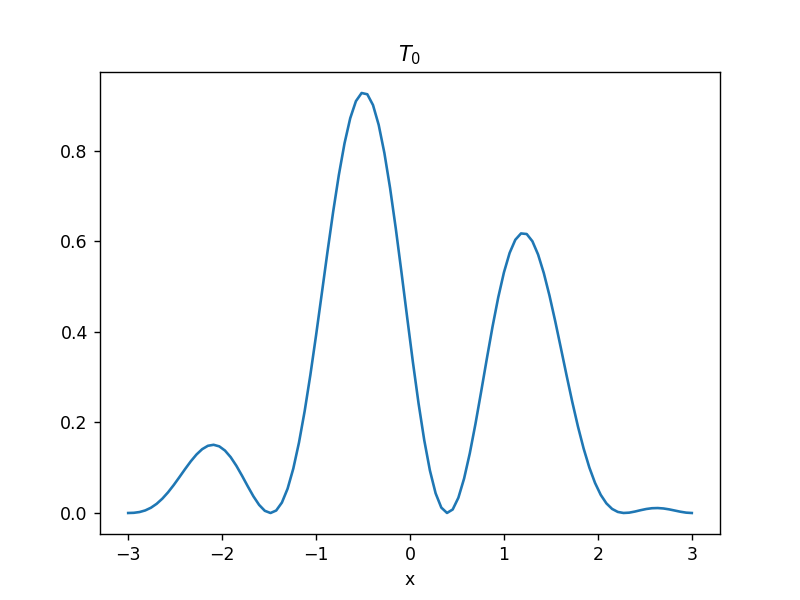

In [6]:
fig,ax     = plt.subplots(dpi = 100)
T0_eval_im = ax.plot(torch.linspace(DB.a,DB.b,DB.eval_grid_shape[0]),DB.T0_eval.cpu())
ax.set_xlabel("x")
ax.set_title("$T_0$");

<IPython.core.display.Javascript object>


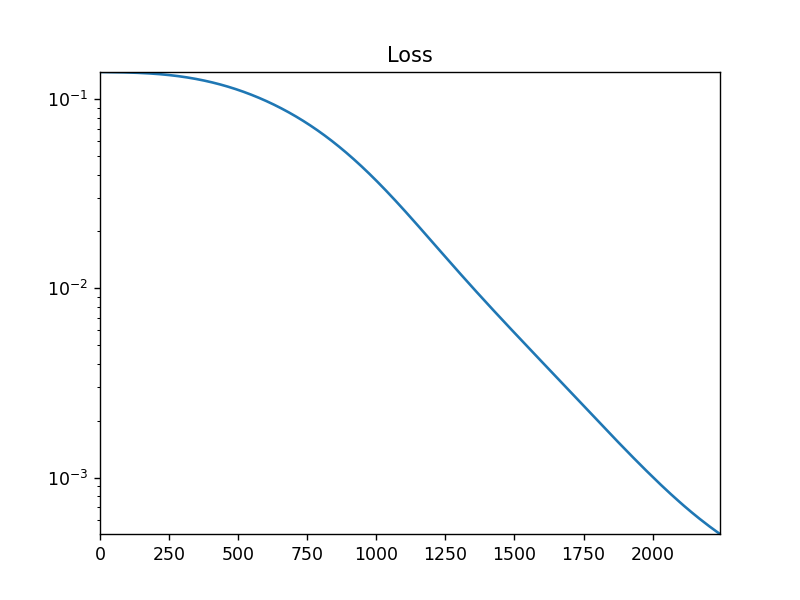

  0%|          | 0/10000 [00:00<?, ?it/s]

Converged


In [7]:
DB.train(maxiter = 10000, eps = 5e-4)

<IPython.core.display.Javascript object>


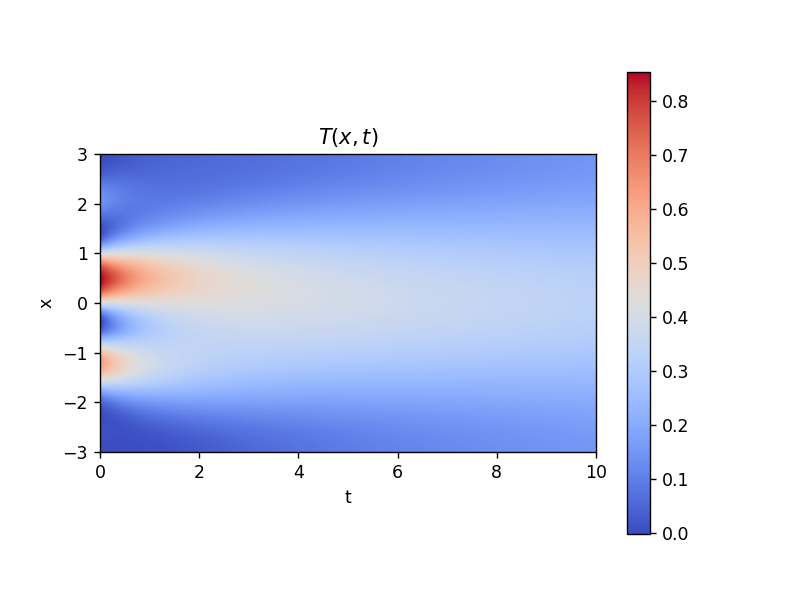

In [8]:
N    = 250

with torch.no_grad():
    grid = DB.eval_grid(N).squeeze().cpu()

fig,ax = plt.subplots(dpi = 100)
im     = ax.imshow(grid, cmap = 'coolwarm', extent = [0,DB.t_end,DB.a,DB.b])
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title("$T(x,t)$")
plt.colorbar(im, ax = ax);

### Conservation

Let's see whether energy is conserved, i.e.
$$
    \int_a^b T(x,t)\text{d}x
$$
is constant in $t$.

<IPython.core.display.Javascript object>


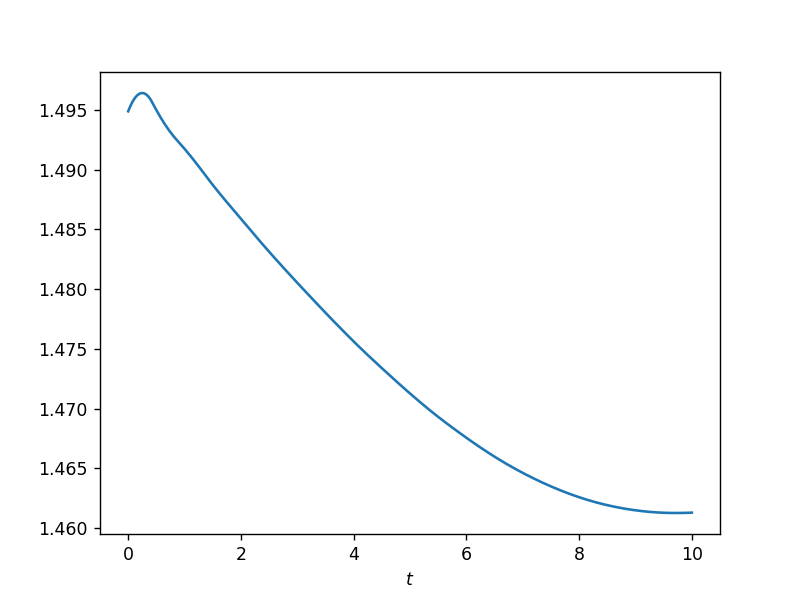

In [9]:
fig,ax = plt.subplots(dpi = 100)

ax.plot(torch.linspace(0,DB.t_end,N),
        grid.sum(dim=0)*(DB.b-DB.a)/(N-1))
ax.set_xlabel("$t$");